# Predicción Lluvia en Australia

La tarea es desarrollar un modelo de aprendizaje que prediga de manera binaria (sí/no) si el día de mañana lloverá (columna RainTomorrow) en una o varias de las ciudades australianas que existen en los datos (columna Location).

In [ ]:
!pip install geopy==2.2.0

     |████████████████████████████████| 118 kB 29.8 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
!pip install category_encoders==2.4.0

     |████████████████████████████████| 86 kB 10.4 MB/s 
     |████████████████████████████████| 233 kB 46.1 MB/s 
     |████████████████████████████████| 9.9 MB 94.9 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from sklearn.model_selection import train_test_split

from geopy.geocoders import Nominatim
import time
import math
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn import metrics #Importa metricas scikit-learn para el calculo del accuracy
from sklearn import preprocessing #Importa funciones para el procesamiento de los datos
from sklearn.metrics import confusion_matrix #Importa los métodos de cálculo de la matriz de confusión
from sklearn.metrics import precision_recall_fscore_support # Importa módulos para calcular métricas a partir de la matriz de confusión
from sklearn.tree import DecisionTreeClassifier # Importa el Decision Tree Classifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


## Análisis Exploratorio de Datos

In [ ]:
# Importar el dataset (.csv)

rain = pd.read_csv('/work/weatherAUS.csv')
rain.head(5)

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [ ]:
#Observar las dimensiones del dataset
rain.shape

(145460, 23)

El dataset tiene 145460 registros y 23 variables.

In [ ]:
#Observar los nombres de las columnas
col_names = rain.columns
col_names

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [ ]:
#Observar información general del dataset
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Información importante con respecto al dataset: 
- Hay valores que faltan en el conjunto de datos
- El conjunto de datos incluye valores numéricos y categóricos (float64 y object)

In [ ]:
#Observar las propiedades estadisticas de las variables numericas del dataset
rain.describe()


MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.000000      13.000000   
50%        8.400000      39.000000      13.000000      19.000000   
75%       10.600000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm   Pressure9am    Pressure3pm  \
count  142806.000000  140953.000000  130395.00000  130432.000000   
mean       68.880831      51.539116    1017.64994    1015.255889   
std        19.029164      20.795902       7.10653       7.037414   
min         0.000000       0.000000     980.50000     977.100000   
25%        57.000000      37.000000    1012.90000    1010.400000   
50%        70.000000      52.000000    1017.60000    1015.200000   
75%        83.000000      66.000000    1022.40000    1020.000000   
max       100.000000     100.000000    1041.00000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am       Temp3pm  
count  89572.000000  86102.000000  143693.000000  141851.00000  
mean       4.447461      4.509930      16.990631      21.68339  
std        2.887159      2.720357       6.488753       6.93665  
min        0.000000      0.000000      -7.200000      -5.40000  
25%        1.000000      2.000000      12.300000      16.60000  
50%        5.000000      5.000000      16.700000      21.10000  
75%        7.000000      7.000000      21.600000      26.40000  
max        9.000000      9.000000      40.200000      46.70000

In [ ]:
rain.describe().shape

(8, 16)

In [ ]:
#Observar las propiedades estadisticas de las variables categoricas del dataset
rain.describe(include=['object'])

Date  Location WindGustDir WindDir9am WindDir3pm RainToday  \
count       145460    145460      135134     134894     141232    142199   
unique        3436        49          16         16         16         2   
top     2013-11-17  Canberra           W          N         SE        No   
freq            49      3436        9915      11758      10838    110319   

       RainTomorrow  
count        142193  
unique            2  
top              No  
freq         110316

In [ ]:
rain.describe(include=['object']).shape

(4, 7)

- Existen 16 variables numericas, 7 categoricas y 1 correspondiente a la fecha.
- El conjunto de datos incluye valores numéricos y categóricos (float64 y object)
- La variable objetivo es RainTomorrow

Se procede a depurar el dataset eliminando los registros con valores faltantes

In [ ]:
#Buscar la cantidad de registros con datos faltantes
rain.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [ ]:
#Remover todas las filas que presenten datos nulos
rain.dropna(subset=['RainTomorrow'],inplace = True)
#rain.reset_index(drop=True,inplace=True)

In [ ]:
rain.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

### Variable Objetivo

Ahora se observa la variable objetivo

In [ ]:
#Frecuencia en la variable objetivo
rain['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [ ]:
#Porcentaje de frecuencia en la variable objetivo
rain['RainTomorrow'].value_counts()/len(rain)

No     0.775819
Yes    0.224181
Name: RainTomorrow, dtype: float64

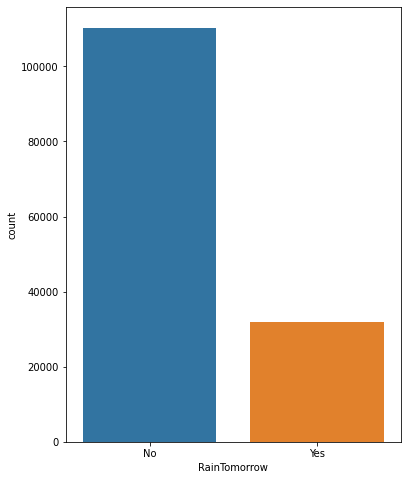

In [ ]:
#Grafico la frecuencia de la variable objetivo
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="RainTomorrow", data=rain)
plt.show()

Los registros se encuentras distribuidos de la siguiente forma: No=110316(77.5819%) y Yes=31877(22.4181%)

### Variables Numericas

In [ ]:
numerical = rain.describe().columns
numerical

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')

In [ ]:
rain[numerical].head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0     13.4     22.9       0.6          NaN       NaN           44.0   
1      7.4     25.1       0.0          NaN       NaN           44.0   
2     12.9     25.7       0.0          NaN       NaN           46.0   
3      9.2     28.0       0.0          NaN       NaN           24.0   
4     17.5     32.3       1.0          NaN       NaN           41.0   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0          20.0          24.0         71.0         22.0       1007.7   
1           4.0          22.0         44.0         25.0       1010.6   
2          19.0          26.0         38.0         30.0       1007.6   
3          11.0           9.0         45.0         16.0       1017.6   
4           7.0          20.0         82.0         33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  
0       1007.1       8.0       NaN     16.9     21.8  
1       1007.8       NaN       NaN     17.2     24.3  
2       1008.7       NaN       2.0     21.0     23.2  
3       1012.8       NaN       NaN     18.1     26.5  
4       1006.0       7.0       8.0     17.8     29.7

In [ ]:
rain[numerical].isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
dtype: int64

In [ ]:
rain[numerical].nunique()

MinTemp          389
MaxTemp          505
Rainfall         679
Evaporation      356
Sunshine         145
WindGustSpeed     67
WindSpeed9am      43
WindSpeed3pm      44
Humidity9am      101
Humidity3pm      101
Pressure9am      546
Pressure3pm      549
Cloud9am          10
Cloud3pm          10
Temp9am          440
Temp3pm          500
dtype: int64

### Variables Categoricas

In [ ]:
categorical = rain.describe(include=['object']).columns
categorical 

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
       'RainToday', 'RainTomorrow'],
      dtype='object')

In [ ]:
rain[categorical].head()


Date Location WindGustDir WindDir9am WindDir3pm RainToday  \
0  2008-12-01   Albury           W          W        WNW        No   
1  2008-12-02   Albury         WNW        NNW        WSW        No   
2  2008-12-03   Albury         WSW          W        WSW        No   
3  2008-12-04   Albury          NE         SE          E        No   
4  2008-12-05   Albury           W        ENE         NW        No   

  RainTomorrow  
0           No  
1           No  
2           No  
3           No  
4           No

In [ ]:
rain[categorical].isnull().sum()

Date                0
Location            0
WindGustDir      9330
WindDir9am      10013
WindDir3pm       3778
RainToday        1406
RainTomorrow        0
dtype: int64

Se presentan valores faltantes, por lo tanto es necesario tratarlos.

In [ ]:
rain[categorical].nunique()

Date            3436
Location          49
WindGustDir       16
WindDir9am        16
WindDir3pm        16
RainToday          2
RainTomorrow       2
dtype: int64

La variable Date tiene gran cantidad de registros unicos, por lo que es necesario realizar un preprocesamiento.

In [ ]:
rain['Date'] = pd.to_datetime(rain['Date'])

In [ ]:
rain['Year'] = rain['Date'].dt.year
rain['Month'] = rain['Date'].dt.month
rain['Day'] = rain['Date'].dt.day
rain.drop('Date', axis=1, inplace = True)

fechas = pd.concat([rain['Year'], rain['Month'],rain['Day']], axis=1)
fechas.head()

Year  Month  Day
0  2008     12    1
1  2008     12    2
2  2008     12    3
3  2008     12    4
4  2008     12    5

In [ ]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   Evaporation    81350 non-null   float64
 5   Sunshine       74377 non-null   float64
 6   WindGustDir    132863 non-null  object 
 7   WindGustSpeed  132923 non-null  float64
 8   WindDir9am     132180 non-null  object 
 9   WindDir3pm     138415 non-null  object 
 10  WindSpeed9am   140845 non-null  float64
 11  WindSpeed3pm   139563 non-null  float64
 12  Humidity9am    140419 non-null  float64
 13  Humidity3pm    138583 non-null  float64
 14  Pressure9am    128179 non-null  float64
 15  Pressure3pm    128212 non-null  float64
 16  Cloud9am       88536 non-null   float64
 17  Cloud3pm       85099 non-null

In [ ]:
Ciudades = rain.Location.unique()
Ciudades

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

Es necesario convertir variables categoricas en numericas, esto se realiza con el método One Hot Encoding.

In [ ]:
pd.get_dummies(rain.Location, drop_first=True).head()

Albany  Albury  AliceSprings  BadgerysCreek  Ballarat  Bendigo  Brisbane  \
0       0       1             0              0         0        0         0   
1       0       1             0              0         0        0         0   
2       0       1             0              0         0        0         0   
3       0       1             0              0         0        0         0   
4       0       1             0              0         0        0         0   

   Cairns  Canberra  Cobar  ...  Townsville  Tuggeranong  Uluru  WaggaWagga  \
0       0         0      0  ...           0            0      0           0   
1       0         0      0  ...           0            0      0           0   
2       0         0      0  ...           0            0      0           0   
3       0         0      0  ...           0            0      0           0   
4       0         0      0  ...           0            0      0           0   

   Walpole  Watsonia  Williamtown  Witchcliffe  Wollongong  Woomera  
0        0         0            0            0           0        0  
1        0         0            0            0           0        0  
2        0         0            0            0           0        0  
3        0         0            0            0           0        0  
4        0         0            0            0           0        0  

[5 rows x 48 columns]

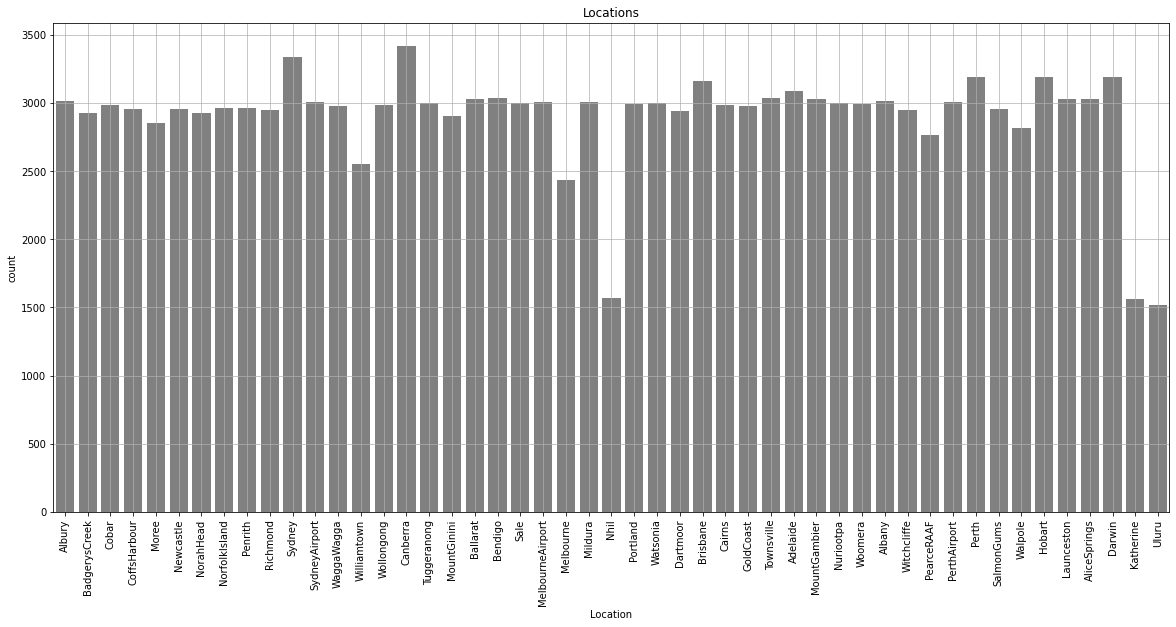

In [ ]:
plt.figure(figsize=(20,9))
plt.style.use("default")
plt.title('Locations')
ax = sns.countplot(data=rain, x="Location", color= 'gray')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.grid(linewidth = 0.7)
plt.show()

In [ ]:
pd.get_dummies(rain.WindGustDir, drop_first=True).head()

ENE  ESE  N  NE  NNE  NNW  NW  S  SE  SSE  SSW  SW  W  WNW  WSW
0    0    0  0   0    0    0   0  0   0    0    0   0  1    0    0
1    0    0  0   0    0    0   0  0   0    0    0   0  0    1    0
2    0    0  0   0    0    0   0  0   0    0    0   0  0    0    1
3    0    0  0   1    0    0   0  0   0    0    0   0  0    0    0
4    0    0  0   0    0    0   0  0   0    0    0   0  1    0    0

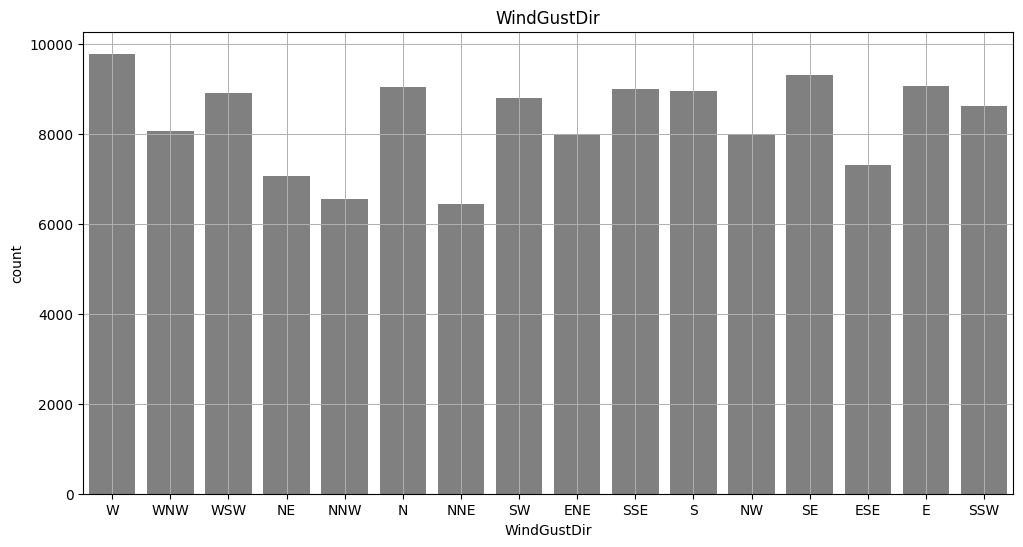

In [ ]:
plt.figure(figsize=(12,6))
plt.style.use("default")
plt.title('WindGustDir')
ax = sns.countplot(data=rain, x="WindGustDir", color= 'gray')
ax.set_xticklabels(ax.get_xticklabels())
plt.grid(linewidth = 0.7)
plt.show()

In [ ]:
pd.get_dummies(rain.WindDir9am, drop_first=True).head()

ENE  ESE  N  NE  NNE  NNW  NW  S  SE  SSE  SSW  SW  W  WNW  WSW
0    0    0  0   0    0    0   0  0   0    0    0   0  1    0    0
1    0    0  0   0    0    1   0  0   0    0    0   0  0    0    0
2    0    0  0   0    0    0   0  0   0    0    0   0  1    0    0
3    0    0  0   0    0    0   0  0   1    0    0   0  0    0    0
4    1    0  0   0    0    0   0  0   0    0    0   0  0    0    0

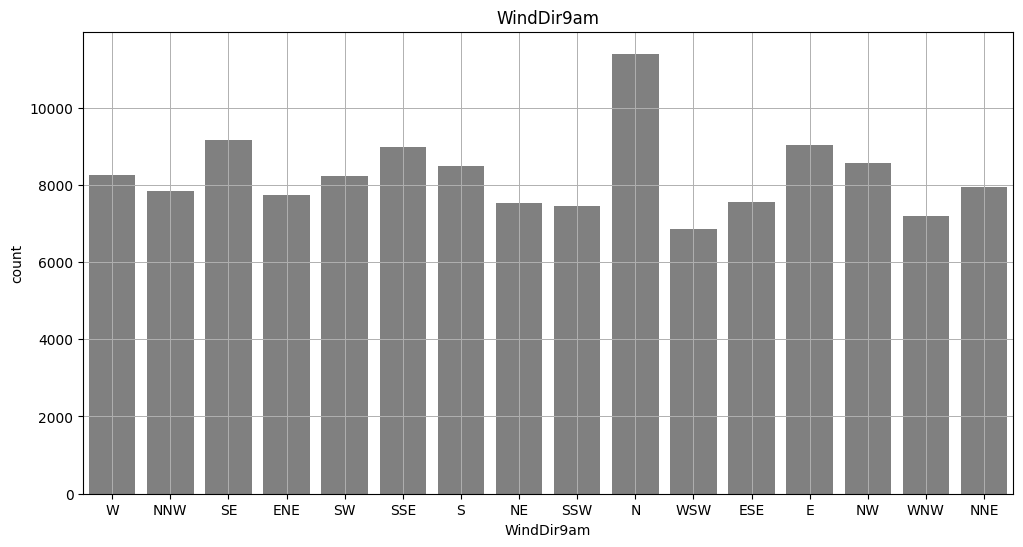

In [ ]:
plt.figure(figsize=(12,6))
plt.style.use("default")
plt.title('WindDir9am')
ax = sns.countplot(data=rain, x="WindDir9am", color= 'gray')
ax.set_xticklabels(ax.get_xticklabels())
plt.grid(linewidth = 0.7)
plt.show()

In [ ]:
pd.get_dummies(rain.WindDir3pm, drop_first=True).head()

ENE  ESE  N  NE  NNE  NNW  NW  S  SE  SSE  SSW  SW  W  WNW  WSW
0    0    0  0   0    0    0   0  0   0    0    0   0  0    1    0
1    0    0  0   0    0    0   0  0   0    0    0   0  0    0    1
2    0    0  0   0    0    0   0  0   0    0    0   0  0    0    1
3    0    0  0   0    0    0   0  0   0    0    0   0  0    0    0
4    0    0  0   0    0    0   1  0   0    0    0   0  0    0    0

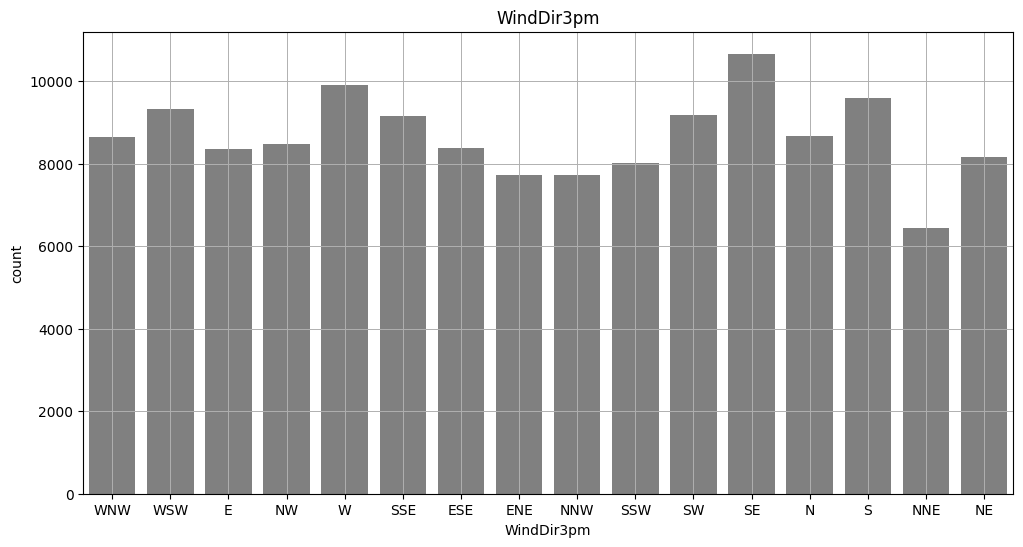

In [ ]:
plt.figure(figsize=(12,6))
plt.style.use("default")
plt.title('WindDir3pm')
ax = sns.countplot(data=rain, x="WindDir3pm", color= 'gray')
ax.set_xticklabels(ax.get_xticklabels())
plt.grid(linewidth = 0.7)
plt.show()

In [ ]:
pd.get_dummies(rain.RainToday, drop_first=True).head()

Yes
0    0
1    0
2    0
3    0
4    0

## Visualización efectiva de Datos

In [ ]:
#Mostrar el tamaño del dataset filtrado con el que se va a trabajar el proyecto
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Indicator(mode = "number", value = rain.shape[0], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "🧾 Rows<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0, 0.5], 'y': [0.6, 1]}))
fig.add_trace(go.Indicator(mode = "number", value = rain.shape[1], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "⭕ Columns<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0.5, 1], 'y': [0, 0.4]}))
fig.show()

In [ ]:
Ciudades.tolist()

['Albury',
 'BadgerysCreek',
 'Cobar',
 'CoffsHarbour',
 'Moree',
 'Newcastle',
 'NorahHead',
 'NorfolkIsland',
 'Penrith',
 'Richmond',
 'Sydney',
 'SydneyAirport',
 'WaggaWagga',
 'Williamtown',
 'Wollongong',
 'Canberra',
 'Tuggeranong',
 'MountGinini',
 'Ballarat',
 'Bendigo',
 'Sale',
 'MelbourneAirport',
 'Melbourne',
 'Mildura',
 'Nhil',
 'Portland',
 'Watsonia',
 'Dartmoor',
 'Brisbane',
 'Cairns',
 'GoldCoast',
 'Townsville',
 'Adelaide',
 'MountGambier',
 'Nuriootpa',
 'Woomera',
 'Albany',
 'Witchcliffe',
 'PearceRAAF',
 'PerthAirport',
 'Perth',
 'SalmonGums',
 'Walpole',
 'Hobart',
 'Launceston',
 'AliceSprings',
 'Darwin',
 'Katherine',
 'Uluru']

In [ ]:
#¿Donde están ubicadas las viviendas?
# Crear Objeto Nominatim
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="AppMap")

location_lista = ['Albury','Badgerys Creek','Cobar','Coffs Harbour','Moree','Newcastle','Norah Head','Norfolk Island','Penrith',
 'Richmond','Sydney','Sydney Airport','Wagga Wagga','Williamtown','Wollongong','Canberra','Tuggeranong','Mount Ginini','Ballarat',
 'Bendigo','Sale','Melbourne Airport','Melbourne','Mildura','Nhil','Portland','Watsonia','Dartmoor','Brisbane','Cairns','GoldCoast',
 'Townsville','Adelaide','Mount Gambier','Nuriootpa','Woomera','Albany','Witchcliffe','Pearce RAAF','Perth Airport','Perth','SalmonGums',
 'Walpole','Hobart','Launceston','Alice Springs','Darwin','Katherine','Uluru']

In [ ]:
latitud = []
longitud = []
#Recorremos la lista
for i in location_lista:
    address = geolocator.geocode(i, timeout=10)
    if address is not None:
        ciudad = location_lista
        latitud.append(address.latitude)
        longitud.append(address.longitude)
    else:
        print(f"Could not find Location for {address!r}")

Could not find Location for None


In [ ]:
# extrayendo los valores de longitud y latitud a listas separadas
longs = longitud
lats = latitud
# crear un objeto mapa base usando Map()
mapObj = folium.Map(location=[-24.89611610752976, 133.54713377264966], zoom_start = 4)
# crear capa de mapa de calor
heatmap = HeatMap( list(zip(lats, longs)),
                   min_opacity=0.5,
                   radius=50, blur=50, 
                   max_zoom=1)
# añadir capa de mapa de calor al mapa base
heatmap.add_to(mapObj)
mapObj

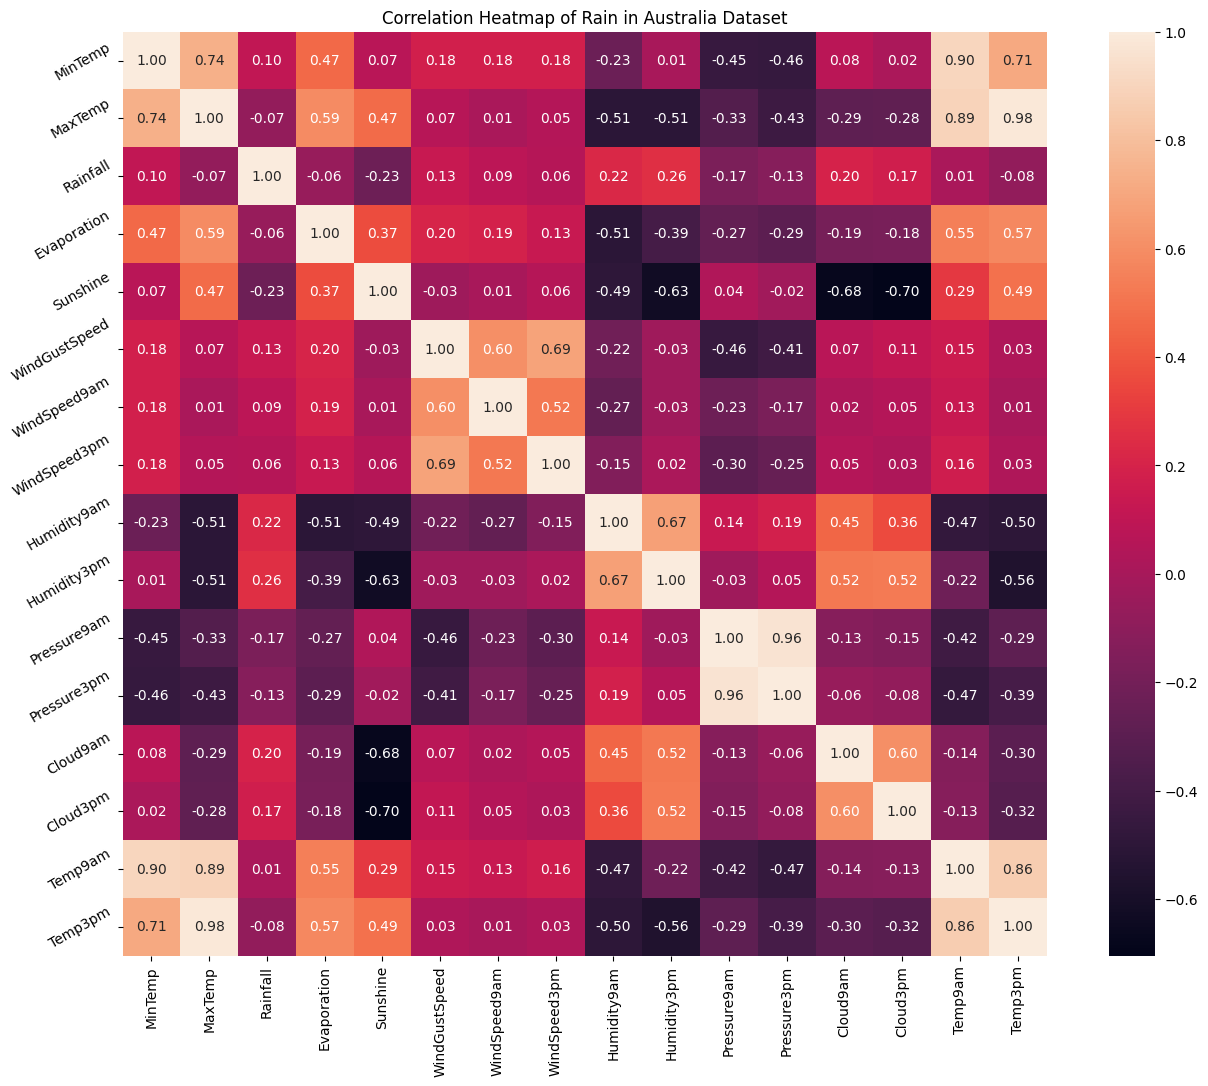

In [ ]:
correlation = rain[numerical].corr()
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Rain in Australia Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

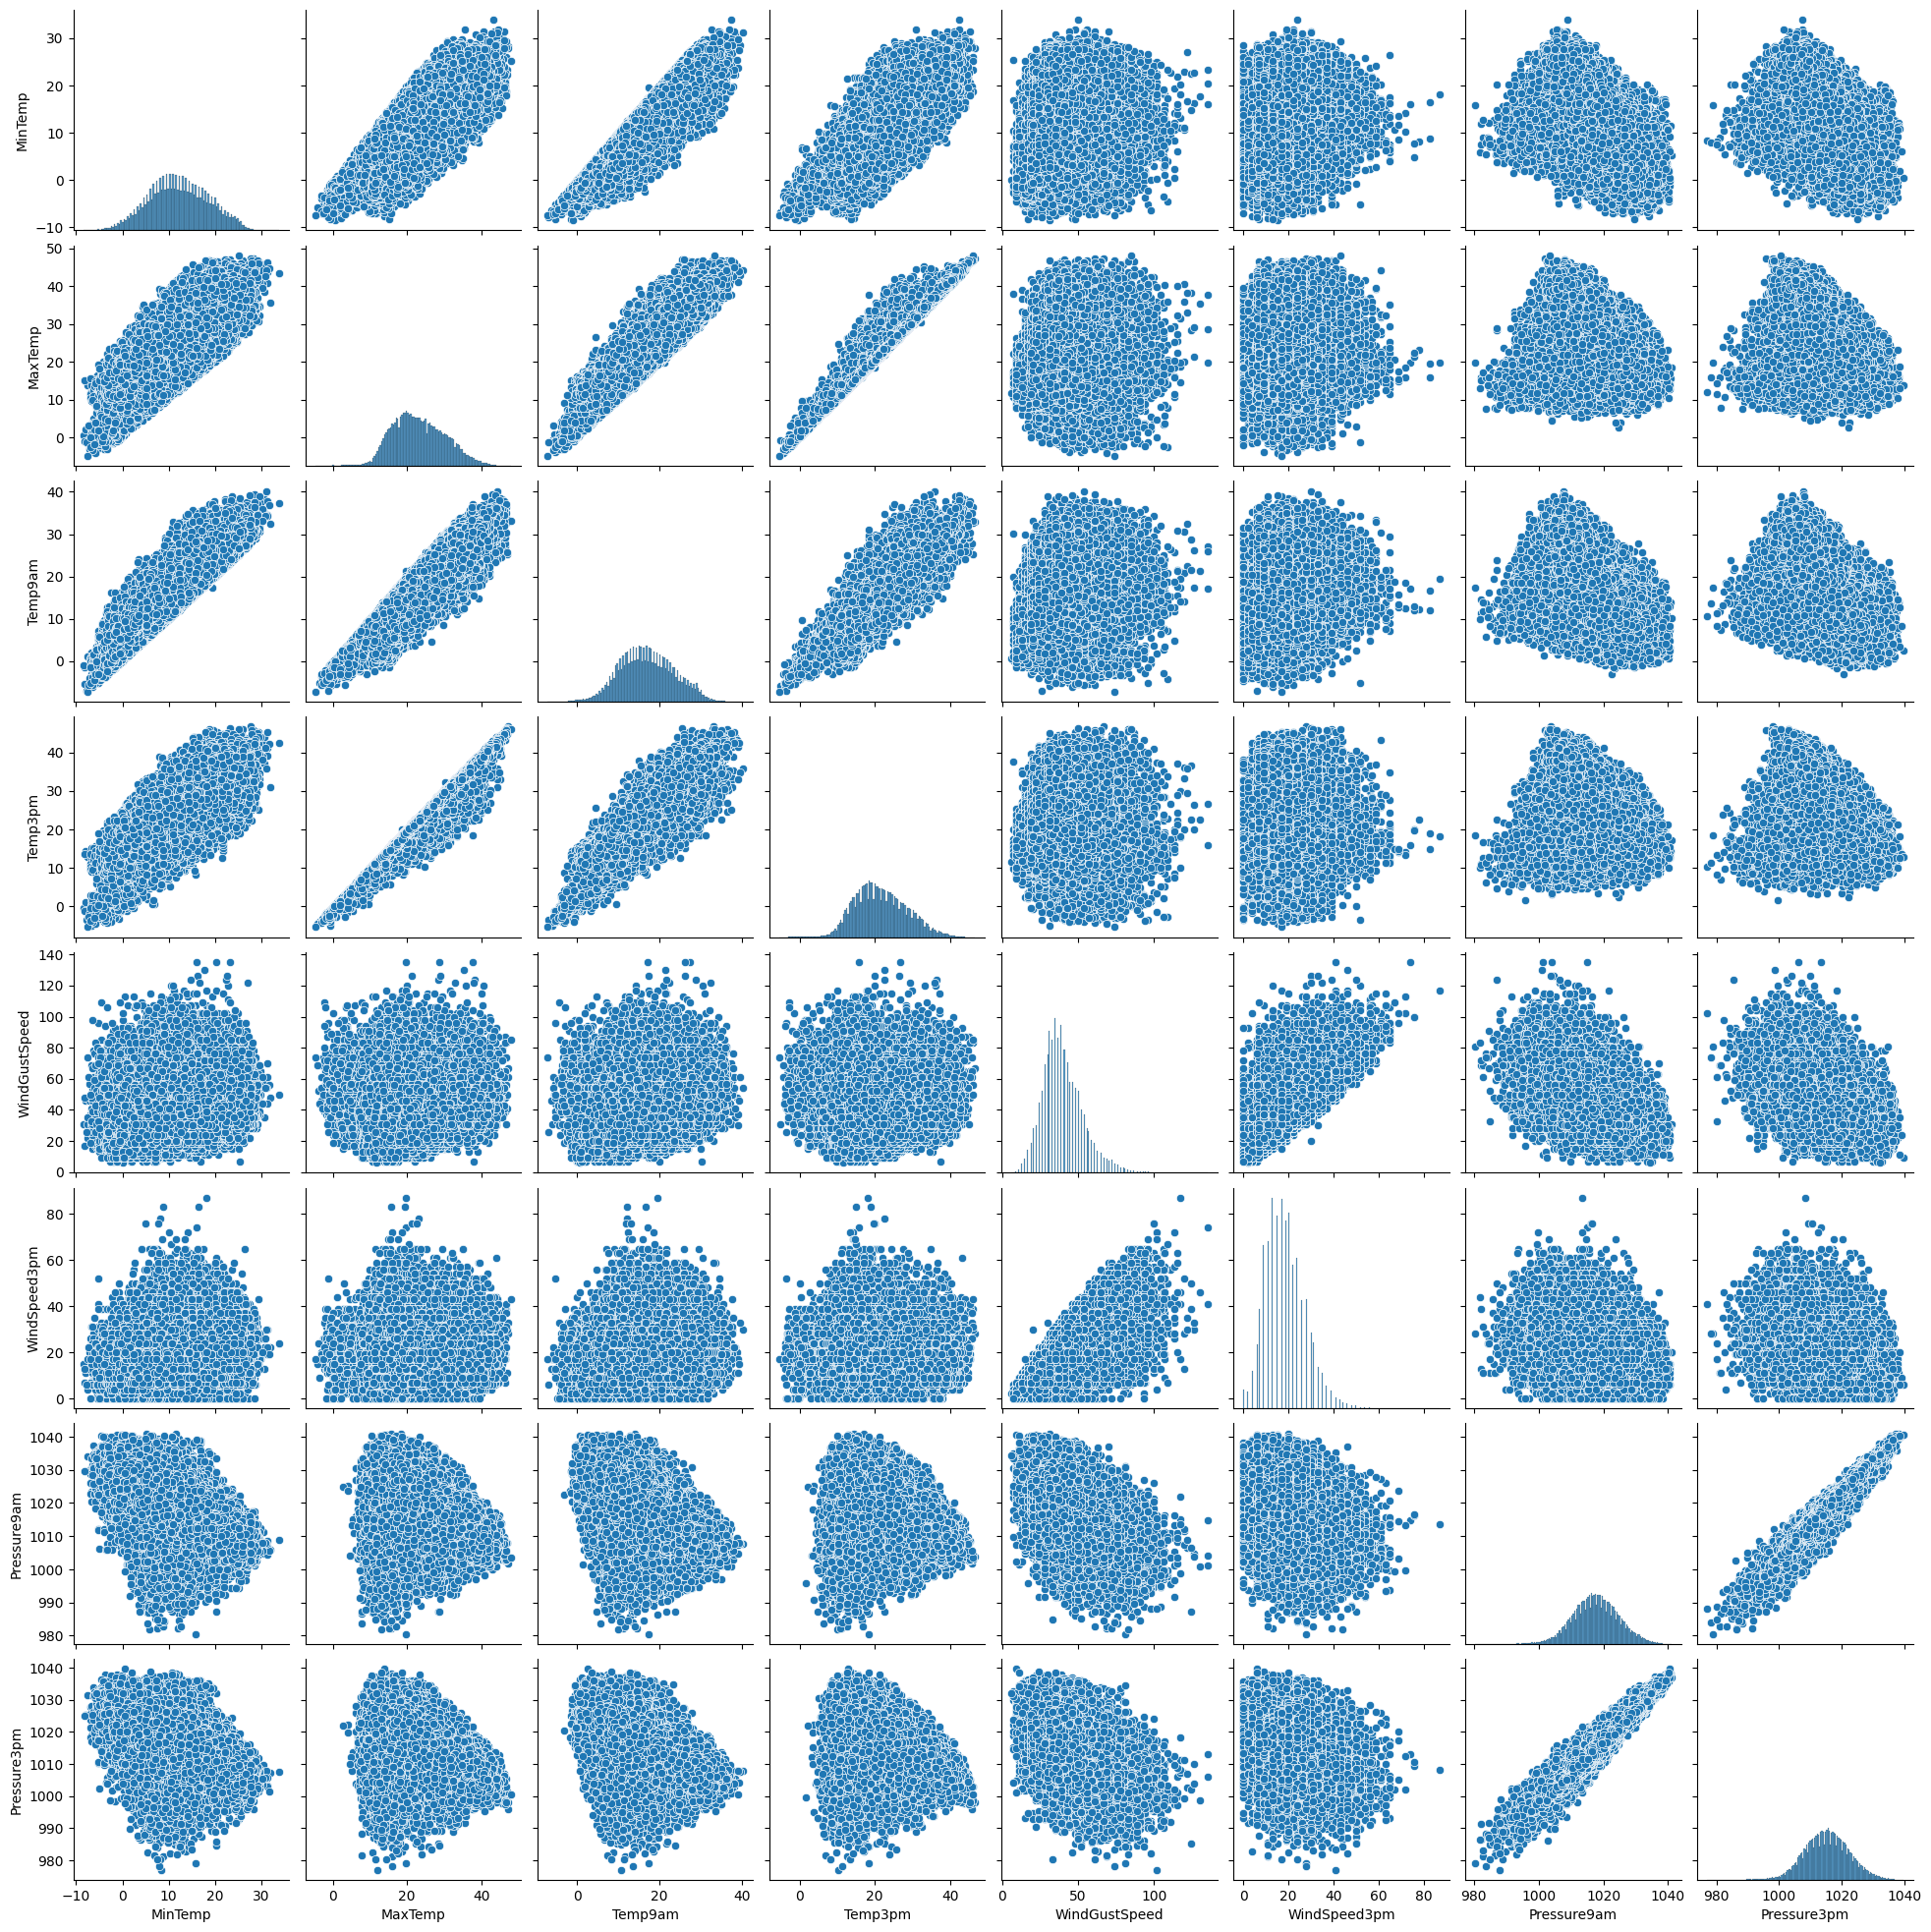

In [ ]:
corr_var = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm']
sns.pairplot(rain[corr_var], kind='scatter', diag_kind='hist', palette='Rainbow')
plt.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/sha

<AxesSubplot:xlabel='Pressure3pm', ylabel='Density'>

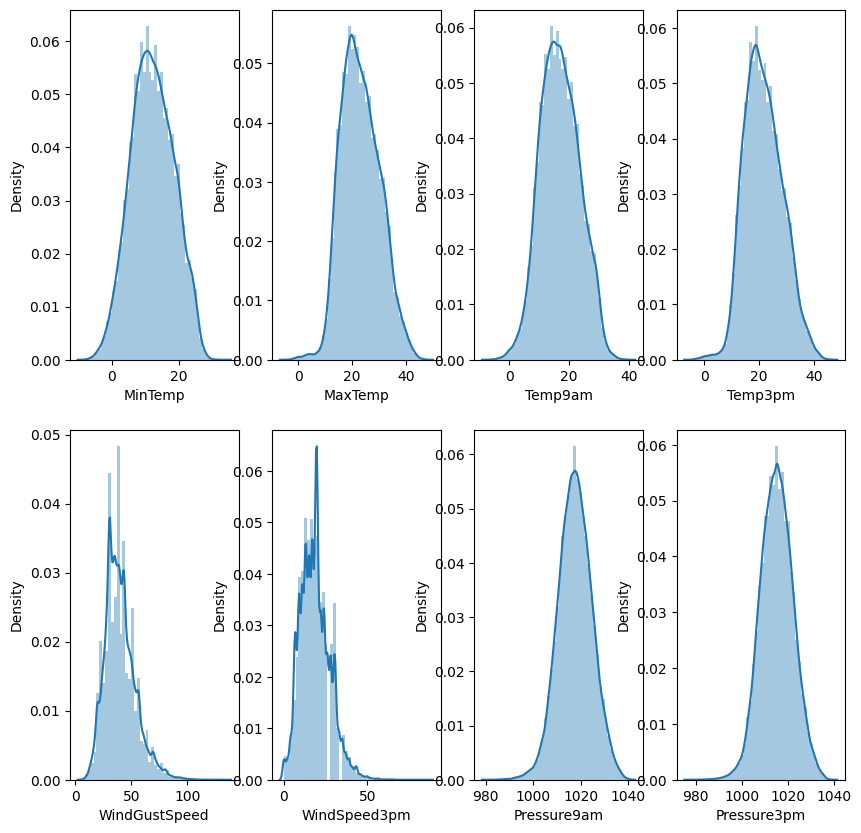

In [ ]:
#['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm']

plt.figure(figsize=(10,10))

plt.subplot(2, 4, 1)
sns.distplot(rain['MinTemp'])
plt.subplot(2, 4, 2)
sns.distplot(rain['MaxTemp'])

plt.subplot(2, 4, 3)
sns.distplot(rain['Temp9am'])
plt.subplot(2, 4, 4)
sns.distplot(rain['Temp3pm'])

plt.subplot(2, 4, 5)
sns.distplot(rain['WindGustSpeed'])
plt.subplot(2, 4, 6)
sns.distplot(rain['WindSpeed3pm'])

plt.subplot(2, 4, 7)
sns.distplot(rain['Pressure9am'])
plt.subplot(2, 4, 8)
sns.distplot(rain['Pressure3pm'])

## Ingeniería de características

### Variables Numericas

Se presentan valores faltantes, por lo tanto es necesario tratarlos.

In [ ]:
for i in rain:
    if rain[i].dtype=='float64':
        rain[i].replace(to_replace=np.nan, value=rain[i].median(), inplace=True)

In [ ]:
rain[numerical].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

Ahora se buscan los posibles Outliers presentes en las variables numericas

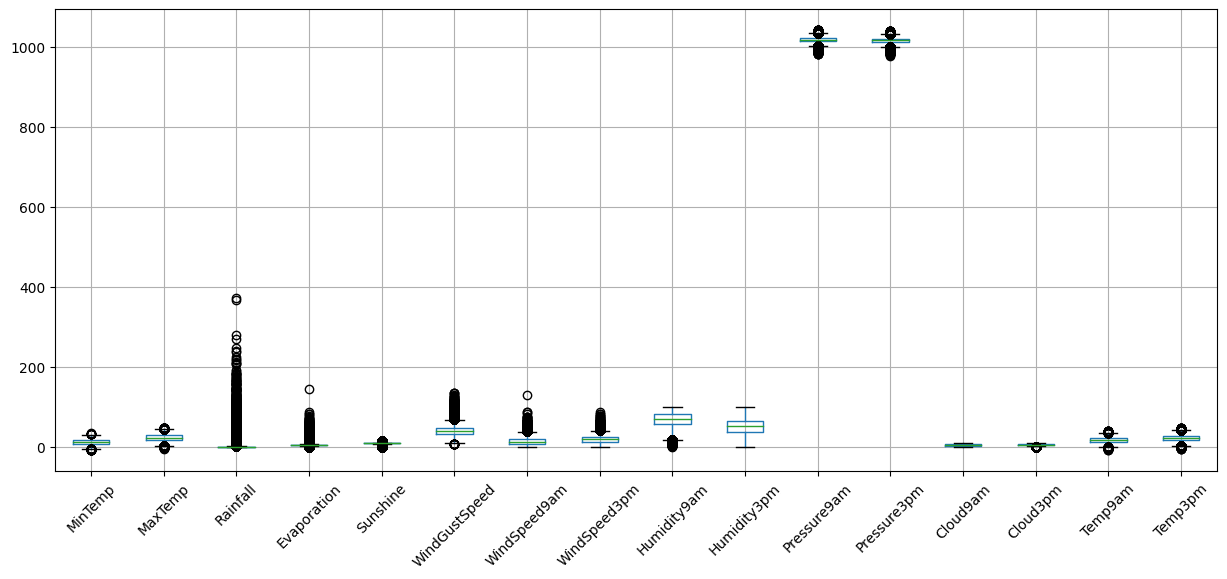

In [ ]:
#Se analizan visualmente las variables para observar posibles outliers
plt.figure(figsize=[15,6])
rain.boxplot(column= ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'])
plt.xticks(rotation=45)
plt.show()

In [ ]:
for i in rain:
    if rain[i].dtype=='float64':
        Q1 = rain[i].quantile(0.25)
        Q3 = rain[i].quantile(0.75)
        IQR = Q3-Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mediana = np.median(rain[i])
        for m in rain[i]:
            if m > upper or m < lower:
                rain[i] = rain[i].replace(m, mediana)

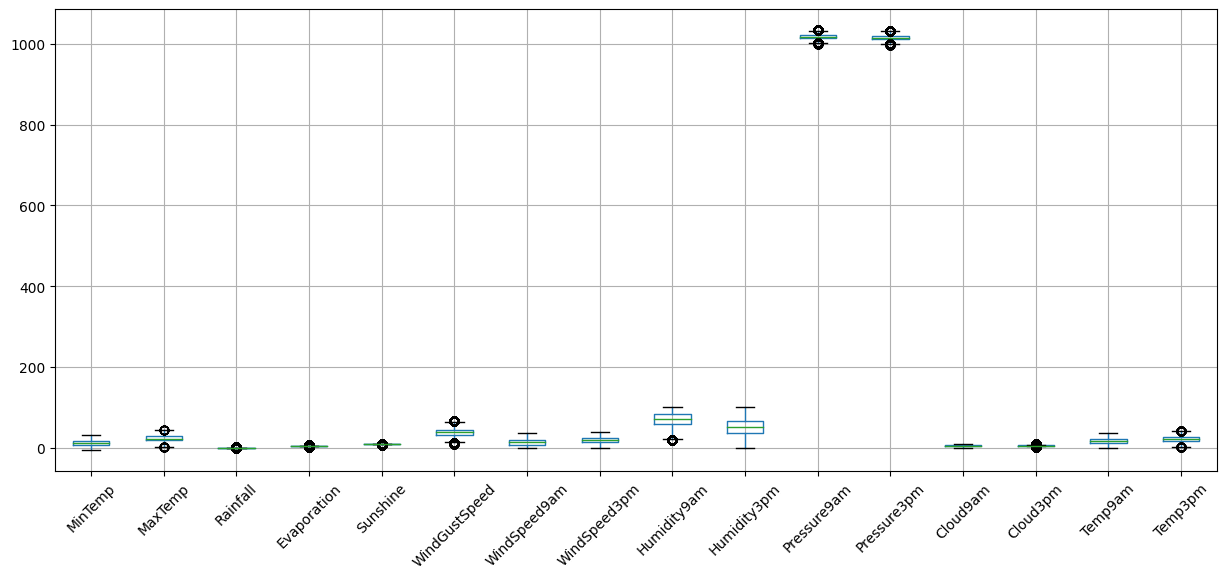

In [ ]:
#Se analizan visualmente las variables para observar posibles outliers
plt.figure(figsize=[15,6])
rain.boxplot(column= ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'])
plt.xticks(rotation=45)
plt.show()

### Variables Categoricas

In [ ]:
rain['WindGustDir'].fillna(rain['WindGustDir'].mode()[0], inplace=True)
rain['WindDir9am'].fillna(rain['WindDir9am'].mode()[0], inplace=True)
rain['WindDir3pm'].fillna(rain['WindDir3pm'].mode()[0], inplace=True)
rain['RainToday'].fillna(rain['RainToday'].mode()[0], inplace=True)

In [ ]:
rain.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Year             0
Month            0
Day              0
dtype: int64

In [ ]:
rain.describe()


MinTemp        MaxTemp       Rainfall    Evaporation  \
count  142193.000000  142193.000000  142193.000000  142193.000000   
mean       12.191098      23.245757       0.084318       4.688992   
std         6.376435       6.994391       0.249493       0.941171   
min        -6.200000       2.500000       0.000000       1.900000   
25%         7.600000      18.000000       0.000000       4.800000   
50%        12.000000      22.600000       0.000000       4.800000   
75%        16.800000      28.200000       0.000000       4.800000   
max        30.500000      43.600000       1.500000       7.500000   

            Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  142193.000000  142193.000000  142193.000000  142193.000000   
mean        8.502585      38.493400      13.609861      18.186064   
std         0.178154      10.770849       8.156412       7.930880   
min         7.500000       9.000000       0.000000       0.000000   
25%         8.500000      31.000000       7.000000      13.000000   
50%         8.500000      39.000000      13.000000      19.000000   
75%         8.500000      44.000000      19.000000      24.000000   
max         9.400000      67.000000      37.000000      39.000000   

         Humidity9am    Humidity3pm    Pressure9am    Pressure3pm  \
count  142193.000000  142193.000000  142193.000000  142193.000000   
mean       69.429944      51.495742    1017.722501    1015.296813   
std        18.070162      20.532227       6.173476       6.195322   
min        18.000000       0.000000    1001.100000     998.500000   
25%        58.000000      37.000000    1013.800000    1011.200000   
50%        70.000000      52.000000    1017.600000    1015.200000   
75%        83.000000      65.000000    1021.600000    1019.200000   
max       100.000000     100.000000    1034.200000    1032.000000   

            Cloud9am       Cloud3pm        Temp9am        Temp3pm  \
count  142193.000000  142193.000000  142193.000000  142193.000000   
mean        4.649568       4.876963      16.997624      21.669295   
std         2.294357       1.921161       6.410063       6.677537   
min         0.000000       1.000000      -1.400000       2.300000   
25%         3.000000       5.000000      12.300000      16.800000   
50%         5.000000       5.000000      16.700000      21.100000   
75%         6.000000       6.000000      21.500000      26.200000   
max         9.000000       9.000000      35.300000      40.700000   

                Year          Month            Day  
count  142193.000000  142193.000000  142193.000000  
mean     2012.758926       6.402544      15.715084  
std         2.541256       3.426506       8.798150  
min      2007.000000       1.000000       1.000000  
25%      2011.000000       3.000000       8.000000  
50%      2013.000000       6.000000      16.000000  
75%      2015.000000       9.000000      23.000000  
max      2017.000000      12.000000      31.000000

In [ ]:
ce_bin = ce.BinaryEncoder(cols=['RainToday'])

rain = ce_bin.fit_transform(rain)

In [ ]:
rain


Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0        Albury     13.4     22.9       0.6          4.8       8.5   
1        Albury      7.4     25.1       0.0          4.8       8.5   
2        Albury     12.9     25.7       0.0          4.8       8.5   
3        Albury      9.2     28.0       0.0          4.8       8.5   
4        Albury     17.5     32.3       1.0          4.8       8.5   
...         ...      ...      ...       ...          ...       ...   
145454    Uluru      3.5     21.8       0.0          4.8       8.5   
145455    Uluru      2.8     23.4       0.0          4.8       8.5   
145456    Uluru      3.6     25.3       0.0          4.8       8.5   
145457    Uluru      5.4     26.9       0.0          4.8       8.5   
145458    Uluru      7.8     27.0       0.0          4.8       8.5   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Cloud9am  \
0                W           44.0          W        WNW  ...       8.0   
1              WNW           44.0        NNW        WSW  ...       5.0   
2              WSW           46.0          W        WSW  ...       5.0   
3               NE           24.0         SE          E  ...       5.0   
4                W           41.0        ENE         NW  ...       7.0   
...            ...            ...        ...        ...  ...       ...   
145454           E           31.0        ESE          E  ...       5.0   
145455           E           31.0         SE        ENE  ...       5.0   
145456         NNW           22.0         SE          N  ...       5.0   
145457           N           37.0         SE        WNW  ...       5.0   
145458          SE           28.0        SSE          N  ...       3.0   

        Cloud3pm  Temp9am  Temp3pm  RainToday_0  RainToday_1  RainTomorrow  \
0            5.0     16.9     21.8            0            1            No   
1            5.0     17.2     24.3            0            1            No   
2            2.0     21.0     23.2            0            1            No   
3            5.0     18.1     26.5            0            1            No   
4            8.0     17.8     29.7            0            1            No   
...          ...      ...      ...          ...          ...           ...   
145454       5.0      9.4     20.9            0            1            No   
145455       5.0     10.1     22.4            0            1            No   
145456       5.0     10.9     24.5            0            1            No   
145457       5.0     12.5     26.1            0            1            No   
145458       2.0     15.1     26.0            0            1            No   

        Year  Month  Day  
0       2008     12    1  
1       2008     12    2  
2       2008     12    3  
3       2008     12    4  
4       2008     12    5  
...      ...    ...  ...  
145454  2017      6   20  
145455  2017      6   21  
145456  2017      6   22  
145457  2017      6   23  
145458  2017      6   24  

[142193 rows x 26 columns]

In [ ]:
rain_final = pd.concat([rain[numerical], rain[['RainToday_0', 'RainToday_1']],
                     pd.get_dummies(rain.Location), 
                     pd.get_dummies(rain.WindGustDir),
                     pd.get_dummies(rain.WindDir9am),
                     pd.get_dummies(rain.WindDir3pm),
                     rain.RainTomorrow], axis=1)

rain_final.head(20)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0      13.4     22.9       0.6          4.8       8.5           44.0   
1       7.4     25.1       0.0          4.8       8.5           44.0   
2      12.9     25.7       0.0          4.8       8.5           46.0   
3       9.2     28.0       0.0          4.8       8.5           24.0   
4      17.5     32.3       1.0          4.8       8.5           41.0   
5      14.6     29.7       0.2          4.8       8.5           56.0   
6      14.3     25.0       0.0          4.8       8.5           50.0   
7       7.7     26.7       0.0          4.8       8.5           35.0   
8       9.7     31.9       0.0          4.8       8.5           39.0   
9      13.1     30.1       1.4          4.8       8.5           28.0   
10     13.4     30.4       0.0          4.8       8.5           30.0   
11     15.9     21.7       0.0          4.8       8.5           31.0   
12     15.9     18.6       0.0          4.8       8.5           61.0   
13     12.6     21.0       0.0          4.8       8.5           44.0   
15      9.8     27.7       0.0          4.8       8.5           50.0   
16     14.1     20.9       0.0          4.8       8.5           22.0   
17     13.5     22.9       0.0          4.8       8.5           63.0   
18     11.2     22.5       0.0          4.8       8.5           43.0   
19      9.8     25.6       0.0          4.8       8.5           26.0   
20     11.5     29.3       0.0          4.8       8.5           24.0   

    WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  NW  S  SE  SSE  \
0           20.0          24.0         71.0         22.0  ...   0  0   0    0   
1            4.0          22.0         44.0         25.0  ...   0  0   0    0   
2           19.0          26.0         38.0         30.0  ...   0  0   0    0   
3           11.0           9.0         45.0         16.0  ...   0  0   0    0   
4            7.0          20.0         82.0         33.0  ...   1  0   0    0   
5           19.0          24.0         55.0         23.0  ...   0  0   0    0   
6           20.0          24.0         49.0         19.0  ...   0  0   0    0   
7            6.0          17.0         48.0         19.0  ...   0  0   0    0   
8            7.0          28.0         42.0          9.0  ...   1  0   0    0   
9           15.0          11.0         58.0         27.0  ...   0  0   0    1   
10          17.0           6.0         48.0         22.0  ...   0  0   0    0   
11          15.0          13.0         89.0         91.0  ...   0  0   0    0   
12          28.0          28.0         76.0         93.0  ...   0  0   0    0   
13          24.0          20.0         65.0         43.0  ...   0  0   0    0   
15          13.0          22.0         50.0         28.0  ...   0  0   0    0   
16          11.0           9.0         69.0         82.0  ...   0  0   0    0   
17           6.0          20.0         80.0         65.0  ...   0  0   0    0   
18          24.0          17.0         47.0         32.0  ...   0  0   0    0   
19          17.0           6.0         45.0         26.0  ...   0  0   0    0   
20           9.0           9.0         56.0         28.0  ...   0  0   1    0   

    SSW  SW  W  WNW  WSW  RainTomorrow  
0     0   0  0    1    0            No  
1     0   0  0    0    1            No  
2     0   0  0    0    1            No  
3     0   0  0    0    0            No  
4     0   0  0    0    0            No  
5     0   0  1    0    0            No  
6     0   0  1    0    0            No  
7     0   0  1    0    0            No  
8     0   0  0    0    0           Yes  
9     0   0  0    0    0            No  
10    0   0  0    0    0           Yes  
11    0   0  0    0    0           Yes  
12    0   0  0    0    0           Yes  
13    1   0  0    0    0            No  
15    0   0  0    1    0            No  
16    0   0  0    0    0           Yes  
17    0   0  0    1    0           Yes  
18    0   1  0    0    0            No  
19    0   

In [ ]:
rain_final.shape

(142193, 116)

In [ ]:
#Mostrar el tamaño del dataset filtrado con el que se va a trabajar el proyecto
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Indicator(mode = "number", value = rain_final.shape[0], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "🧾 Rows<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0, 0.5], 'y': [0.6, 1]}))
fig.add_trace(go.Indicator(mode = "number", value = rain_final.shape[1], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "⭕ Columns<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0.5, 1], 'y': [0, 0.4]}))
fig.show()

## Modelado

Se definen las variables de entrada y salida a utilizar con los algoritmos

In [ ]:
#Selecciono mi variable objetivo y sus predictores

X = rain_final.drop(['RainTomorrow'], axis=1)

y = rain_final['RainTomorrow']

In [ ]:
X.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0     13.4     22.9       0.6          4.8       8.5           44.0   
1      7.4     25.1       0.0          4.8       8.5           44.0   
2     12.9     25.7       0.0          4.8       8.5           46.0   
3      9.2     28.0       0.0          4.8       8.5           24.0   
4     17.5     32.3       1.0          4.8       8.5           41.0   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  NNW  NW  S  SE  \
0          20.0          24.0         71.0         22.0  ...    0   0  0   0   
1           4.0          22.0         44.0         25.0  ...    0   0  0   0   
2          19.0          26.0         38.0         30.0  ...    0   0  0   0   
3          11.0           9.0         45.0         16.0  ...    0   0  0   0   
4           7.0          20.0         82.0         33.0  ...    0   1  0   0   

   SSE  SSW  SW  W  WNW  WSW  
0    0    0   0  0    1    0  
1    0    0   0  0    0    1  
2    0    0   0  0    0    1  
3    0    0   0  0    0    0  
4    0    0   0  0    0    0  

[5 rows x 115 columns]

In [ ]:
X.shape

(142193, 115)

In [ ]:
nombre_columnas = X.columns
nombre_columnas

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW'],
      dtype='object', length=115)

In [ ]:
minmax = MinMaxScaler()

X = minmax.fit_transform(X)
X = pd.DataFrame(X,columns=[nombre_columnas])
X

MinTemp   MaxTemp  Rainfall Evaporation  Sunshine WindGustSpeed  \
0       0.534060  0.496350  0.400000    0.517857  0.526316      0.603448   
1       0.370572  0.549878  0.000000    0.517857  0.526316      0.603448   
2       0.520436  0.564477  0.000000    0.517857  0.526316      0.637931   
3       0.419619  0.620438  0.000000    0.517857  0.526316      0.258621   
4       0.645777  0.725061  0.666667    0.517857  0.526316      0.551724   
...          ...       ...       ...         ...       ...           ...   
142188  0.264305  0.469586  0.000000    0.517857  0.526316      0.379310   
142189  0.245232  0.508516  0.000000    0.517857  0.526316      0.379310   
142190  0.267030  0.554745  0.000000    0.517857  0.526316      0.224138   
142191  0.316076  0.593674  0.000000    0.517857  0.526316      0.482759   
142192  0.381471  0.596107  0.000000    0.517857  0.526316      0.327586   

       WindSpeed9am WindSpeed3pm Humidity9am Humidity3pm  ...  NNW   NW    S  \
0          0.540541     0.615385    0.646341        0.22  ...  0.0  0.0  0.0   
1          0.108108     0.564103    0.317073        0.25  ...  0.0  0.0  0.0   
2          0.513514     0.666667    0.243902        0.30  ...  0.0  0.0  0.0   
3          0.297297     0.230769    0.329268        0.16  ...  0.0  0.0  0.0   
4          0.189189     0.512821    0.780488        0.33  ...  0.0  1.0  0.0   
...             ...          ...         ...         ...  ...  ...  ...  ...   
142188     0.405405     0.333333    0.500000        0.27  ...  0.0  0.0  0.0   
142189     0.351351     0.282051    0.402439        0.24  ...  0.0  0.0  0.0   
142190     0.351351     0.230769    0.463415        0.21  ...  0.0  0.0  0.0   
142191     0.243243     0.230769    0.426829        0.24  ...  0.0  0.0  0.0   
142192     0.351351     0.179487    0.402439        0.24  ...  0.0  0.0  0.0   

         SE  SSE  SSW   SW    W  WNW  WSW  
0       0.0  0.0  0.0  0.0  0.0  1.0  0.0  
1       0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2       0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3       0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  
142188  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
142189  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
142190  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
142191  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
142192  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[142193 rows x 115 columns]

In [ ]:
X.describe()

MinTemp        MaxTemp       Rainfall    Evaporation  \
count  142193.000000  142193.000000  142193.000000  142193.000000   
mean        0.501120       0.504763       0.056212       0.498034   
std         0.173745       0.170180       0.166329       0.168066   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.376022       0.377129       0.000000       0.517857   
50%         0.495913       0.489051       0.000000       0.517857   
75%         0.626703       0.625304       0.000000       0.517857   
max         1.000000       1.000000       1.000000       1.000000   

            Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  142193.000000  142193.000000  142193.000000  142193.000000   
mean        0.527676       0.508507       0.367834       0.466309   
std         0.093765       0.185704       0.220444       0.203356   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.526316       0.379310       0.189189       0.333333   
50%         0.526316       0.517241       0.351351       0.487179   
75%         0.526316       0.603448       0.513514       0.615385   
max         1.000000       1.000000       1.000000       1.000000   

         Humidity9am    Humidity3pm  ...            NNW             NW  \
count  142193.000000  142193.000000  ...  142193.000000  142193.000000   
mean        0.627194       0.514957  ...       0.054384       0.059553   
std         0.220368       0.205322  ...       0.226774       0.236657   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.487805       0.370000  ...       0.000000       0.000000   
50%         0.634146       0.520000  ...       0.000000       0.000000   
75%         0.792683       0.650000  ...       0.000000       0.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

                   S             SE            SSE            SSW  \
count  142193.000000  142193.000000  142193.000000  142193.000000   
mean        0.067500       0.101559       0.064293       0.056332   
std         0.250886       0.302069       0.245275       0.230562   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

                  SW              W            WNW            WSW  
count  142193.000000  142193.000000  142193.000000  142193.000000  
mean        0.064574       0.069701       0.060875       0.065608  
std         0.245774       0.254643       0.239102       0.247597  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 115 columns]

In [ ]:
#Divido el conjunto de datos en prueba y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = False)

In [ ]:
#Observo el tamaño de los conjuntos de datos

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((113754, 115), (28439, 115), (113754,), (28439,))

In [ ]:
X_train

MinTemp   MaxTemp  Rainfall Evaporation  Sunshine WindGustSpeed  \
0       0.534060  0.496350  0.400000    0.517857  0.526316      0.603448   
1       0.370572  0.549878  0.000000    0.517857  0.526316      0.603448   
2       0.520436  0.564477  0.000000    0.517857  0.526316      0.637931   
3       0.419619  0.620438  0.000000    0.517857  0.526316      0.258621   
4       0.645777  0.725061  0.666667    0.517857  0.526316      0.551724   
...          ...       ...       ...         ...       ...           ...   
113749  0.591281  0.647202  0.000000    0.517857  0.526316      0.551724   
113750  0.544959  0.411192  0.000000    0.517857  0.526316      0.896552   
113751  0.373297  0.474453  0.000000    0.517857  0.526316      0.517241   
113752  0.318801  0.581509  0.000000    0.517857  0.526316      0.448276   
113753  0.583106  0.756691  0.000000    0.517857  0.526316      0.517241   

       WindSpeed9am WindSpeed3pm Humidity9am Humidity3pm  ...  NNW   NW    S  \
0          0.540541     0.615385    0.646341        0.22  ...  0.0  0.0  0.0   
1          0.108108     0.564103    0.317073        0.25  ...  0.0  0.0  0.0   
2          0.513514     0.666667    0.243902        0.30  ...  0.0  0.0  0.0   
3          0.297297     0.230769    0.329268        0.16  ...  0.0  0.0  0.0   
4          0.189189     0.512821    0.780488        0.33  ...  0.0  1.0  0.0   
...             ...          ...         ...         ...  ...  ...  ...  ...   
113749     0.513514     0.717949    0.658537        0.55  ...  0.0  0.0  0.0   
113750     0.297297     0.666667    0.841463        0.76  ...  0.0  0.0  0.0   
113751     0.297297     0.717949    0.634146        0.57  ...  0.0  0.0  0.0   
113752     0.351351     0.384615    0.609756        0.34  ...  0.0  0.0  0.0   
113753     0.513514     0.846154    0.365854        0.56  ...  0.0  0.0  0.0   

         SE  SSE  SSW   SW    W  WNW  WSW  
0       0.0  0.0  0.0  0.0  0.0  1.0  0.0  
1       0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2       0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3       0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  
113749  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
113750  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
113751  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
113752  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
113753  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[113754 rows x 115 columns]

In [ ]:
X_test

MinTemp   MaxTemp Rainfall Evaporation  Sunshine WindGustSpeed  \
113754  0.509537  0.527981      0.0    0.517857  0.526316      0.517241   
113755  0.411444  0.608273      0.0    0.517857  0.526316      0.482759   
113756  0.498638  0.513382      0.0    0.517857  0.263158      0.517241   
113757  0.354223  0.610706      0.0    0.517857  0.526316      0.603448   
113758  0.514986  0.688564      0.0    0.517857  0.368421      0.586207   
...          ...       ...      ...         ...       ...           ...   
142188  0.264305  0.469586      0.0    0.517857  0.526316      0.379310   
142189  0.245232  0.508516      0.0    0.517857  0.526316      0.379310   
142190  0.267030  0.554745      0.0    0.517857  0.526316      0.224138   
142191  0.316076  0.593674      0.0    0.517857  0.526316      0.482759   
142192  0.381471  0.596107      0.0    0.517857  0.526316      0.327586   

       WindSpeed9am WindSpeed3pm Humidity9am Humidity3pm  ...  NNW   NW    S  \
113754     0.351351     0.615385    0.792683        0.56  ...  0.0  0.0  0.0   
113755     0.459459     0.564103    0.463415        0.42  ...  0.0  0.0  0.0   
113756     0.648649     0.615385    0.560976        0.54  ...  0.0  0.0  0.0   
113757     0.405405     0.794872    0.475610        0.42  ...  0.0  0.0  0.0   
113758     0.594595     0.333333    0.353659        0.31  ...  0.0  0.0  1.0   
...             ...          ...         ...         ...  ...  ...  ...  ...   
142188     0.405405     0.333333    0.500000        0.27  ...  0.0  0.0  0.0   
142189     0.351351     0.282051    0.402439        0.24  ...  0.0  0.0  0.0   
142190     0.351351     0.230769    0.463415        0.21  ...  0.0  0.0  0.0   
142191     0.243243     0.230769    0.426829        0.24  ...  0.0  0.0  0.0   
142192     0.351351     0.179487    0.402439        0.24  ...  0.0  0.0  0.0   

         SE  SSE  SSW   SW    W  WNW  WSW  
113754  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
113755  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
113756  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
113757  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
113758  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  
142188  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
142189  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
142190  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
142191  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
142192  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[28439 rows x 115 columns]

In [ ]:
y_train

0          No
1          No
2          No
3          No
4          No
         ... 
116645     No
116648    Yes
116649     No
116650     No
116651    Yes
Name: RainTomorrow, Length: 113754, dtype: object

In [ ]:
y_test

116652     No
116653     No
116655    Yes
116656     No
116657     No
         ... 
145454     No
145455     No
145456     No
145457     No
145458     No
Name: RainTomorrow, Length: 28439, dtype: object

### Regresión Logistica

In [ ]:
# instantiate the model
regresion_logistica = LogisticRegression(solver='liblinear', random_state=0)


# fit the model
regresion_logistica.fit(X_train, y_train)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
y_pred = regresion_logistica.predict(X_test)

print("Accuracy: \n",metrics.accuracy_score(y_test, y_pred))

Accuracy: 
 0.8585744927740075
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [ ]:
# Accuracy, permite identificar qué tan confiable es el modelo. Qué tantas predicciones correctas realizó? Se compara el valor original en y_test con el valor predicho en y_pred
print("Matriz de confusión: \n", confusion_matrix(y_test, y_pred))

print("Matriz de confusión normalizada: \n", confusion_matrix(y_test, y_pred, normalize="true"))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN,FP,FN,TP \n", (tn, fp, fn, tp))


Matriz de confusión: 
 [[21424  1272]
 [ 2750  2993]]
Matriz de confusión normalizada: 
 [[0.94395488 0.05604512]
 [0.47884381 0.52115619]]
TN,FP,FN,TP 
 (21424, 1272, 2750, 2993)


In [ ]:
# Ahora calcularemos las métricas derivadas de la matriz de confusión
print("Precision, recall y fscore (por clase): \n",precision_recall_fscore_support(y_test, y_pred, average=None)) # Calcula las métricas por cada clase
print("Precision, recall y fscore (macro): \n",precision_recall_fscore_support(y_test, y_pred, average='macro')) # Cada clase tiene un peso igual, se saca el promedio de la métrica
print("Precision, recall y fscore (micro): \n",precision_recall_fscore_support(y_test, y_pred, average='micro')) # Cada registro (ejemplo) tiene un peso igual
print("Precision, recall y fscore (weighted): \n",precision_recall_fscore_support(y_test, y_pred, average='weighted')) # Se normaliza según el peso de cada clase


Precision, recall y fscore (por clase): 
 (array([0.88624142, 0.7017585 ]), array([0.94395488, 0.52115619]), array([0.91418818, 0.5981215 ]), array([22696,  5743]))
Precision, recall y fscore (macro): 
 (0.7939999579058081, 0.7325555360310212, 0.7561548414351514, None)
Precision, recall y fscore (micro): 
 (0.8585744927740075, 0.8585744927740075, 0.8585744927740075, None)
Precision, recall y fscore (weighted): 
 (0.848986752301337, 0.8585744927740075, 0.8503613602972657, None)


In [ ]:
# Ahora calcularemos las métricas derivadas de la matriz de confusión

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.89      0.94      0.91     22696
         Yes       0.70      0.52      0.60      5743

    accuracy                           0.86     28439
   macro avg       0.79      0.73      0.76     28439
weighted avg       0.85      0.86      0.85     28439



### Árboles de Decisión

In [ ]:
#Crear el Árbol de decisión 
clf = DecisionTreeClassifier(random_state=0, max_depth=3)

# Entrenar el árbol de decisión
clf = clf.fit(X_train,y_train)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [ ]:
#Predecir la variable objetivo en los datos de prueba (probar el modelo)
y_pred = clf.predict(X_test)

print("Accuracy: \n",metrics.accuracy_score(y_test, y_pred))

Accuracy: 
 0.8438412039804494
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [ ]:
# Accuracy, permite identificar qué tan confiable es el modelo. Qué tantas predicciones correctas realizó? Se compara el valor original en y_test con el valor predicho en y_pred
print("Matriz de confusión: \n", confusion_matrix(y_test, y_pred))

print("Matriz de confusión normalizada: \n", confusion_matrix(y_test, y_pred, normalize="true"))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN,FP,FN,TP \n", (tn, fp, fn, tp))

Matriz de confusión: 
 [[22200   496]
 [ 3945  1798]]
Matriz de confusión normalizada: 
 [[0.97814593 0.02185407]
 [0.68692321 0.31307679]]
TN,FP,FN,TP 
 (22200, 496, 3945, 1798)


In [ ]:
# Ahora calcularemos las métricas derivadas de la matriz de confusión

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.85      0.98      0.91     22696
         Yes       0.78      0.31      0.45      5743

    accuracy                           0.84     28439
   macro avg       0.82      0.65      0.68     28439
weighted avg       0.84      0.84      0.82     28439



In [ ]:
def dtree_grid_search(X,y,nfolds):
    #crear un diccionario con todos los valores que se quieren probar
    max_depth = 3 #ponerlo de 10 en 10 hasta 100
    minsamplesplit = 3 #dejarlo de 1 en 1 hasta 10
    minsampleleaf = 3 #dejarlo de 1 en 1 hasta 10
    param_grid = {"max_depth": list(range(1, max_depth+1)),
              "min_samples_split": list(range(1, minsamplesplit+1)),
              "min_samples_leaf": list(range(1, minsampleleaf+1))}
    # Crear el objeto árbol de decisión
    dtree_model=DecisionTreeClassifier()
    #use gridsearch para probar todos los valores
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds ,n_jobs=-1)
    #entrenaremos
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [ ]:
#Acá llamaremos la función para calcular los mejores parámetros
bestparam = dtree_grid_search(X_train,y_train,10)
print ("Los mejores parámetros son", bestparam)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split must 

In [ ]:
# Crear el árbol de decisión con los mejores parámetros el ** es para desempaquetar el objeto dict (diccionario).
clf = DecisionTreeClassifier(**bestparam, random_state=0, class_weight="balanced")

# Entrenar el árbol
clf = clf.fit(X_train,y_train)

#Predecir los valores del conjunto de entrenamiento
y_pred = clf.predict(X_test)

# Calcular el accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

Accuracy: 0.827631070009494
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



### Bosques Aleatorios

In [ ]:
# Crear el clasificador
rforest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)

# Entrenar el Random Forest
rforest.fit(X_train, y_train)



/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)

In [ ]:
#Predecir la variable objetivo en los datos de prueba (probar el modelo)
y_pred = rforest.predict(X_test)

print("Accuracy: \n",metrics.accuracy_score(y_test, y_pred))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

Accuracy: 
 0.8578009072048947


In [ ]:
# Accuracy, permite identificar qué tan confiable es el modelo. Qué tantas predicciones correctas realizó? Se compara el valor original en y_test con el valor predicho en y_pred
print("Accuracy: \n",metrics.accuracy_score(y_test, y_pred))
print("Matriz de confusión: \n", confusion_matrix(y_test, y_pred))
print("Matriz de confusión normalizada: \n", confusion_matrix(y_test, y_pred, normalize="true"))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN,FP,FN,TP \n", (tn, fp, fn, tp))

Accuracy: 
 0.8578009072048947
Matriz de confusión: 
 [[21954   742]
 [ 3302  2441]]
Matriz de confusión normalizada: 
 [[0.96730701 0.03269299]
 [0.57496082 0.42503918]]
TN,FP,FN,TP 
 (21954, 742, 3302, 2441)


In [ ]:
# Ahora calcularemos las métricas derivadas de la matriz de confusión
print("Precision, recall y fscore (por clase): \n",precision_recall_fscore_support(y_test, y_pred, average=None)) # Calcula las métricas por cada clase
print("Precision, recall y fscore (macro): \n",precision_recall_fscore_support(y_test, y_pred, average='macro')) # Cada clase tiene un peso igual, se saca el promedio de la métrica
print("Precision, recall y fscore (micro): \n",precision_recall_fscore_support(y_test, y_pred, average='micro')) # Cada registro (ejemplo) tiene un peso igual
print("Precision, recall y fscore (weighted): \n",precision_recall_fscore_support(y_test, y_pred, average='weighted')) # Se normaliza según el peso de cada clase


Precision, recall y fscore (por clase): 
 (array([0.86925879, 0.76688658]), array([0.96730701, 0.42503918]), array([0.91566567, 0.54694152]), array([22696,  5743]))
Precision, recall y fscore (macro): 
 (0.818072687486609, 0.6961730962908915, 0.7313035924115915, None)
Precision, recall y fscore (micro): 
 (0.8578009072048947, 0.8578009072048947, 0.8578009072048948, None)
Precision, recall y fscore (weighted): 
 (0.8485856448953933, 0.8578009072048947, 0.8412051440792422, None)


In [ ]:
def rforest_grid_search(X,y,nfolds):
    #crear un diccionario con todos los valores que se quieren probar
    param_grid = {"max_depth": [5,20],"min_samples_split": [5,10],
    "min_samples_leaf": [5,10],"n_estimators": [10]}
    # Crear el objeto árbol de decisión
    rforest_model=RandomForestClassifier()
    #use gridsearch para probar todos los valores
    rforest_gscv = GridSearchCV(rforest_model, param_grid, cv=nfolds ,n_jobs=-1)
    #entrenaremos
    rforest_gscv.fit(X, y)
    return rforest_gscv.best_params_

In [ ]:
#Acá llamaremos la función para calcular los mejores parámetros
bestparam_rforest = rforest_grid_search(X_train,y_train,10)
print ("Los mejores parámetros son", bestparam_rforest)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

Los mejores parámetros son {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}


In [ ]:
# Crear el árbol de decisión con los mejores parámetros el ** es para desempaquetar el objeto dict (diccionario).
rforest = RandomForestClassifier(**bestparam_rforest, random_state=0)

# Entrenar el árbol
rforest = rforest.fit(X_train,y_train)

#Predecir los valores del conjunto de entrenamiento
y_pred = rforest.predict(X_test)

# Calcular el accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

Accuracy: 0.8534406976335314
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



### Red Neuronal 

In [ ]:
modelMLP = MLPClassifier(random_state=0, max_iter=10)

modelMLP = modelMLP.fit(X_train,y_train)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.



In [ ]:
y_pred = modelMLP.predict(X_test)

print("Accuracy: \n",metrics.accuracy_score(y_test, y_pred))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

Accuracy: 
 0.8537220014768452


In [ ]:
# Accuracy, permite identificar qué tan confiable es el modelo. Qué tantas predicciones correctas realizó? Se compara el valor original en y_test con el valor predicho en y_pred
print("Accuracy: \n",metrics.accuracy_score(y_test, y_pred))
print("Matriz de confusión: \n", confusion_matrix(y_test, y_pred))
print("Matriz de confusión normalizada: \n", confusion_matrix(y_test, y_pred, normalize="true"))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN,FP,FN,TP \n", (tn, fp, fn, tp))

Accuracy: 
 0.8537220014768452
Matriz de confusión: 
 [[20870  1826]
 [ 2334  3409]]
Matriz de confusión normalizada: 
 [[0.91954529 0.08045471]
 [0.4064078  0.5935922 ]]
TN,FP,FN,TP 
 (20870, 1826, 2334, 3409)


In [ ]:
# Ahora calcularemos las métricas derivadas de la matriz de confusión
print("Precision, recall y fscore (por clase): \n",precision_recall_fscore_support(y_test, y_pred, average=None)) # Calcula las métricas por cada clase
print("Precision, recall y fscore (macro): \n",precision_recall_fscore_support(y_test, y_pred, average='macro')) # Cada clase tiene un peso igual, se saca el promedio de la métrica
print("Precision, recall y fscore (micro): \n",precision_recall_fscore_support(y_test, y_pred, average='micro')) # Cada registro (ejemplo) tiene un peso igual
print("Precision, recall y fscore (weighted): \n",precision_recall_fscore_support(y_test, y_pred, average='weighted')) # Se normaliza según el peso de cada clase


Precision, recall y fscore (por clase): 
 (array([0.89941389, 0.65119389]), array([0.91954529, 0.5935922 ]), array([0.90936819, 0.6210603 ]), array([22696,  5743]))
Precision, recall y fscore (macro): 
 (0.7753038907266097, 0.7565687467620081, 0.7652142470720805, None)
Precision, recall y fscore (micro): 
 (0.8537220014768452, 0.8537220014768452, 0.8537220014768452, None)
Precision, recall y fscore (weighted): 
 (0.8492880986151257, 0.8537220014768452, 0.8511470092520231, None)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0fa0bc36-8b95-4938-8cdb-b0779e978154' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>